In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from util.angle import *
from util.depth import *
from util.path import *
from util.visualizer import *
from util.object_dection import *
from util.selly_vision_api import *

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

#tensorrt model
loaded = tf.saved_model.load("./trt_fp16")
model = loaded.signatures["serving_default"]


ANGLE_CLASS = 18
ANGLE = angle_dict(ANGLE_CLASS)
ANGLE_IMG=angle_img(ANGLE, ANGLE_CLASS)

data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


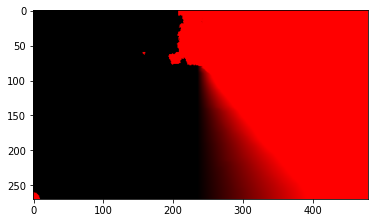

In [5]:
point_copy = point.copy()
point_copy[:, : ,1:] = 0
plt.imshow(point_copy)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


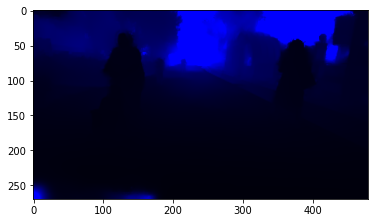

In [11]:
point_copy = point.copy()
point_copy[:, : ,:2] = 0
plt.imshow(point_copy/39)

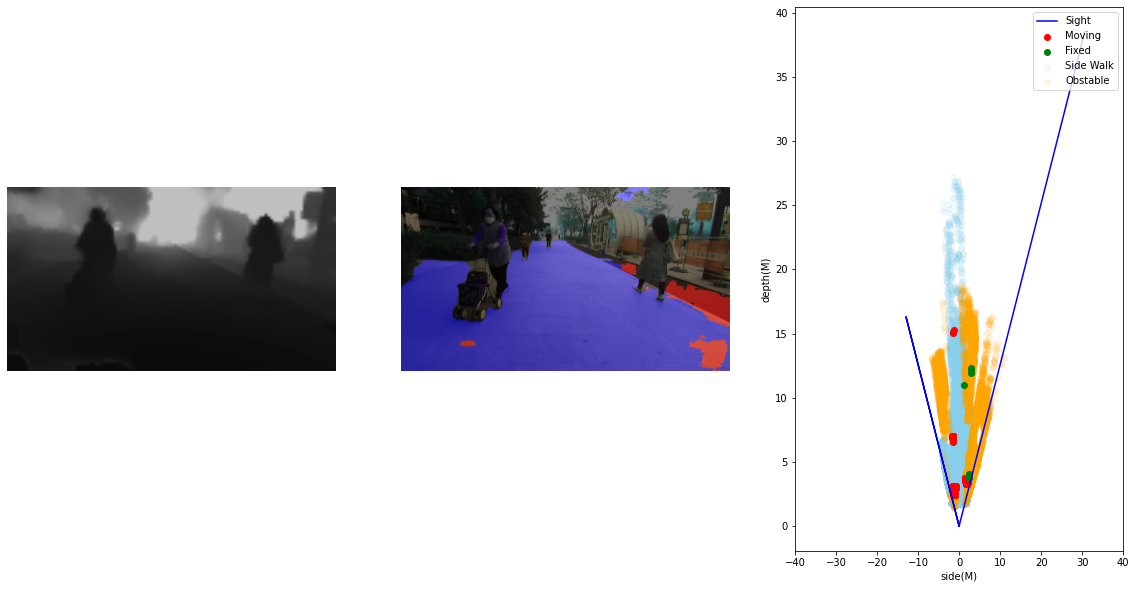

In [184]:
i = 142
point = point_cloud[i].copy()
obj_frame, moving_object, fixed_object  = YOLO(img[i])

plt.figure(figsize=(20,10))



seg,only_sidewalk = seg_predict_visual(img[i],model)

point_copy = point.copy()

point_copy[200 :,:, 2][(point_copy[200 :,:, 2] >5) & (only_sidewalk[200:,:,0] !=0)] = np.mean(point_copy[:,:, 2][(point_copy[:,:, 2]<2)& (only_sidewalk[:,:,0] !=0)])
point_copy[200 :,:, 0][(point_copy[200 :,:, 0] ==np.inf) | (np.abs(point_copy[200 :,:, 0])>2)] = np.mean(point_copy[200:,:, 0][point_copy[200:,:, 0]<2])
point_copy[:,:, 2][point_copy[:,:, 2]==np.inf] = 40
only_sidewalk[(point[:,:,1] < -5) |  (point[:,:,1] ==np.inf)] = 0  #일정 높이 이상 segmetation 오차 제거
point_copy[:,:, 1]=0

depth = point2dist(point_copy,  1)
plt.subplot(1,3,1)
plt.imshow(depth/40)
plt.axis("off")

depth = point.copy()
depth[only_sidewalk==0] = 0

x_min = np.min(point_copy[ : , : , 0])
x_max = np.max(point_copy[ : , : , 0][point_copy[ : , : , 0]!=np.inf])

z_min = np.min(point_copy[ : , : , 2])
z_max = np.max(point_copy[ : , : , 2])
               
    
plt.subplot(1,3,2)
plt.imshow(RGB(seg))
plt.axis("off")


plt.subplot(1,3,3)

plt.plot((0,x_min, 0, x_max), (0,point_copy[np.where(point_copy[ : , : , 0] == x_min)[0][0], 
                                  np.where(point_copy[ : , : , 0] == x_min)[1][0],2],
                              0,
                               point_copy[np.where(point_copy[ : , : , 0] == x_max)[0][0], 
                                  np.where(point_copy[ : , : , 0] == x_max)[1][0],2]), c = "b")

moving_obj_x=[]
moving_obj_z=[]
for i in moving_object:
    obj = point_copy[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , :]
    min_range = np.min(point_copy[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , 2])
    max_range = min_range+0.5
    moving_obj_x.extend(obj[:,:, 0][(obj[:,:, 2] >= min_range) & (obj[:,:, 2] <= max_range)])
    moving_obj_z.extend(obj[:,:, 2][(obj[:,:, 2] >= min_range) & (obj[:,:, 2] <= max_range)])
    depth[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = point_copy[i[0][1] :i[1][1], i[0][0] : i[1][0], :]

plt.scatter(moving_obj_x , moving_obj_z, c='r' , label = 'Moving', zorder=2)

fixed_obj_x=[]
fixed_obj_z=[]
for i in fixed_object:
    obj = point_copy[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , :]
    min_range = np.min(point_copy[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , 2])
    max_range = min_range+0.5
    fixed_obj_x.extend(obj[:,:, 0][(obj[:,:, 2] >= min_range) & (obj[:,:, 2] <= max_range)])
    fixed_obj_z.extend(obj[:,:, 2][(obj[:,:, 2] >= min_range) & (obj[:,:, 2] <= max_range)])
    depth[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = point_copy[i[0][1] :i[1][1], i[0][0] : i[1][0], :]

plt.scatter(fixed_obj_x , fixed_obj_z, c='g', label = 'Fixed', zorder=2)

sidewalk_x = point_copy[:, :, 0][(only_sidewalk[:, :, 0]!=0)]
sidewalk_y = point_copy[:, :, 2][(only_sidewalk[:, :, 2]!=0)]
plt.scatter(sidewalk_x, sidewalk_y, c='skyblue', label = "Side Walk", zorder=0, alpha = 0.1)

plt.xlabel('side(M)')
plt.ylabel('depth(M)')
plt.scatter(px, py, c='orange', label = "Side Walk", zorder=0, alpha = 0.1)
plt.xlim(-40,40)
plt.legend(labels = ["Sight", "Moving", "Fixed","Side Walk", "Obstable"], loc="upper right")

In [11]:
import os
sight_list =os.listdir("sight")
sight_list.sort()
i=0
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('sight.mp4', fourcc, 10.0, (2160,720))
while i<len(sight_list)-1:
    st = time.time()
    img = cv2.imread("sight/"+sight_list[i+1])
    out.write(img)
    print(time.time() - st)
    i+=1
    
out.release()

0.03531908988952637
0.030498981475830078
0.030288219451904297
0.029022216796875
0.029435157775878906
0.02969503402709961
0.02955770492553711
0.029505252838134766
0.029601335525512695
0.02640986442565918
0.033547163009643555
0.029718637466430664
0.030556440353393555
0.029552459716796875
0.02868819236755371
0.027027606964111328
0.02864217758178711
0.030914306640625
0.030998706817626953
0.026898622512817383
0.031482696533203125
0.028132200241088867
0.029742717742919922
0.03366994857788086
0.03081655502319336
0.029722213745117188
0.029271841049194336
0.026781082153320312
0.032340049743652344
0.029008150100708008
0.034169912338256836
0.02974700927734375
0.02929973602294922
0.02969217300415039
0.028823375701904297
0.02973461151123047
0.030408382415771484
0.029217958450317383
0.028382301330566406
0.029638290405273438
0.029374361038208008
0.029421329498291016
0.03188800811767578
0.02926921844482422
0.025084972381591797
0.027001619338989258
0.02487468719482422
0.03311562538146973
0.030333280563

0.029482603073120117
0.02933645248413086
0.02578878402709961
0.029652118682861328
0.028141498565673828
0.027300119400024414
0.0333096981048584
0.03162980079650879
0.025229215621948242
0.028918027877807617
0.03350353240966797
0.02937030792236328
0.02925848960876465
0.029124021530151367
0.031479597091674805
0.028386354446411133
0.02631974220275879
0.033562660217285156
0.02933502197265625
0.029944658279418945
0.029402732849121094
0.03223156929016113
0.03246140480041504
0.02644968032836914
0.0344843864440918
0.026449918746948242
0.0335392951965332
0.0284731388092041
0.030394554138183594
0.032114267349243164
0.025675296783447266
0.03454232215881348
0.02806377410888672
0.028106689453125
0.029030561447143555
0.028917312622070312
0.028344392776489258
0.0293118953704834
0.02896857261657715
0.03079843521118164
0.028336048126220703
0.03298139572143555
0.02619028091430664
0.026907920837402344
0.033232688903808594
0.0295257568359375
0.02939295768737793
0.029318571090698242
0.029171466827392578
0.03

0.029298782348632812
0.02530193328857422
0.03313779830932617
0.029549837112426758
0.029541015625
0.029734134674072266
0.025638580322265625
0.033632516860961914
0.026639461517333984
0.028319358825683594
0.03368043899536133
0.029699087142944336
0.02963566780090332
0.029549121856689453
0.02875685691833496
0.029654502868652344
0.029461383819580078
0.0299532413482666
0.027471065521240234
0.029453039169311523
0.0349278450012207
0.0299532413482666
0.02945709228515625
0.029079675674438477
0.02964186668395996
0.033712148666381836
0.02971816062927246
0.025570154190063477
0.03307080268859863
0.026753664016723633
0.029778718948364258
0.02768087387084961
0.03463935852050781
0.02973484992980957
0.02973175048828125
0.02963876724243164
0.02857208251953125
0.03371882438659668
0.025590896606445312
0.029713153839111328
0.0333552360534668
0.0289459228515625
0.028563499450683594
0.03193068504333496
0.03257441520690918
0.031520843505859375
0.029599905014038086
0.02800130844116211
0.03269672393798828
0.02993

In [9]:
out.release()

In [74]:
i =141

im = img[i].copy()
pt = point_cloud[i].copy()

st = time.time()
for i in range(100):
    selly_vision_redis(im, pt, 5, 5)
print((time.time() - st)/100)

0.05103582620620727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


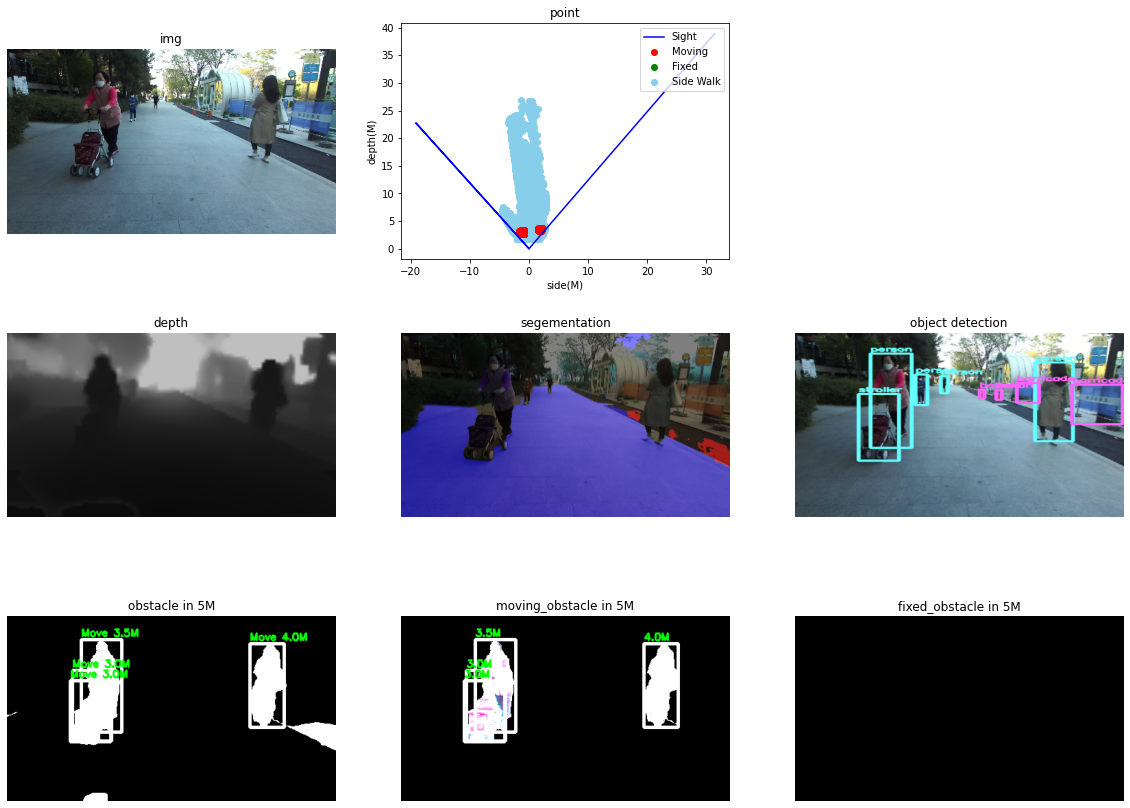

In [2]:
i = 141
#plt.imshow(selly_vision_redis(img[i], point_cloud[i])[0]/255)
visualize(model, img[i], point_cloud[i], 5, 5, ANGLE, ANGLE_CLASS, ANGLE_IMG)

In [10]:
def selly_vision_img(model, img, point_cloud, max_dist, fix_dist, ANGLE, ANGLE_CLASS):
    only_sidewalk = seg_predict(img.copy(),model)
    obj_frame, moving_object, fixed_object  = YOLO(img.copy())
    point = point_cloud.copy()
    point[200 :,:, 2][(point[200 :,:, 2] >5) & (only_sidewalk[200:,:,0] !=0)] = np.mean(point[:,:, 2][(point[:,:, 2]<2)& (only_sidewalk[:,:,0] !=0)])
    point[200 :,:, 1][(point[200 :,:, 1] >3) & (only_sidewalk[200:,:,0] !=0)] = np.mean(point[:,:, 1][(point[:,:, 1]<3)& (only_sidewalk[:,:,0] !=0)])
    point[200 :,:, 0][(point[200 :,:, 0] ==np.inf) | (np.abs(point[200 :,:, 0])>2)] = np.mean(point[200:,:, 0][point[200:,:, 0]<2])
    
    point[:,:, 2][point[:,:, 2]==np.inf] = 40
    only_sidewalk[(point[:,:,1] < -3) |  (point[:,:,1] ==np.inf)] = 0  #일정 높이 이상 segmetation 오차 제거
    point[:,:, 1]=0

    depth = point2dist(point,  1)
    obstacle = np.ones_like(img)
    obstacle[only_sidewalk!=0] = 0

    if len(moving_object):
        moving_object_position = object_dist(moving_object, point.copy(), depth)
        moving_object_position[:, :2] = object_angle(moving_object_position)
    if len(fixed_object):
        fixed_object_position = object_dist(fixed_object, point.copy(), depth)
        fixed_object_position[:, :2] = object_angle(fixed_object_position)
        
    for i in moving_object:
        obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0
    for i in fixed_object:
        obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0    
        
    obstacle[(depth[:,:,2]>fix_dist) | (point[:,:,1] < -3)]=0 #일정 높이 및 깊이 이상 장애물 제거

    plt.imshow(obstacle)
    return moving_object_position, fixed_object_position, obstacle

def object_dist(object_position, point_cloud, depth):
    object_dist_array = []
    for i in object_position:
        obj_position = point_cloud[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , :]
        obj_depth = depth[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , :]
        min_range = np.min(obj_depth)
        max_range = min_range + 1
        x_min =  np.round(np.min(obj_position[:,:, 0][(obj_depth[:,:, 2] >= min_range) & (obj_depth[:,:, 2] <= max_range)]),1)
        x_max =  np.round(np.max(obj_position[:,:, 0][(obj_depth[:,:, 2] >= min_range) & (obj_depth[:,:, 2] <= max_range)]),1)
        object_dist_array.append([x_min, x_max, np.round(min_range,1)])
    object_dist_array = np.array(object_dist_array)
    return object_dist_array

def object_angle(object_dist_array):
    object_angle = []
    seta = np.arctan((object_dist_array[:,1]/object_dist_array[:,2],
                       object_dist_array[:,0]/object_dist_array[:,2]
                     ))/np.pi * 180
    seta = np.round(seta, 1)
    return seta.T

0.0620877742767334


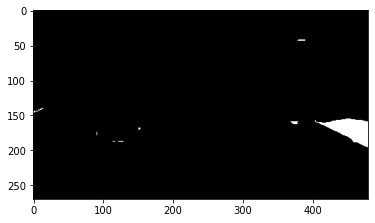

In [11]:
i =141
st = time.time()
moving_object_position, fixed_object_position, obs = selly_vision_img(model, img[i], point_cloud[i], 5, 5, ANGLE, ANGLE_CLASS)
print(time.time() - st)

In [15]:
obs[obs!=0]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [20]:
i =141
moving_obstacle_limit = 5
fixed_obstacle_limit = 5

point = point_cloud[i].copy()
only_sidewalk = seg_predict(img[i].copy(),model)
depth = point2dist(point,  1)
obj_frame, moving_object, fixed_object  = YOLO(img[i].copy())
only_sidewalk[(point[:,:,1] < -3) |  (point[:,:,1] ==np.inf)] = 0  #일정 높이 이상 segmetation 오차 제거

if len(moving_object):
    moving_object_position = object_dist(moving_object, point.copy(), depth)
    moving_object_position[:, :2] = object_angle(moving_object_position)
if len(fixed_object):
    fixed_object_position = object_dist(fixed_object, point.copy(), depth)
    fixed_object_position[:, :2] = object_angle(fixed_object_position)

obstacle = only_sidewalk.copy()
obstacle[(depth[:,:,2]>fixed_obstacle_limit) | (point[:,:,1] < -3)]=0 #일정 높이 및 깊이 이상 장애물 제거

for i in moving_object:
    obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0
for i in fixed_object:
    obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0    
    


In [21]:
angle_max = int(np.max(point[:,:,0][point[:,:,0]!= np.inf]))
angle_min = int(np.min(point[:,:,0]))
able_angle = [ i for i in range(angle_min, angle_max, 1) ] 

for i in moving_object_position:
    if i[2] <5:
        for j in range(int(i[1])-1, int(i[0])+1, 1):
            if j in able_angle:
                able_angle.remove(j)
            
for i in fixed_object_position:
    if i[2] <5:
        for j in range(int(i[1])-1, int(i[0])+1,1 ):
            if j in able_angle:
                able_angle.remove(j)

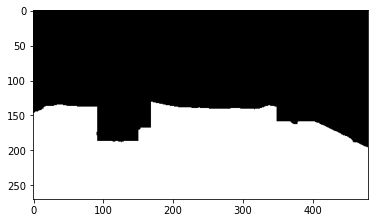

In [5]:
plt.imshow(obs)

In [267]:
for i in able_angle:
obs[(obs!=0) & (point[:,:,0] >)]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [192]:
angle_img = img[141].copy()
angle_img[:, :, 0][(angle_img[:, :, 0] !=0) & (angle_img[:, :, 2] !=0)]  = np.arctan(point[:, :, 0][(angle_img[:, :, 0] !=0) & (angle_img[:, :, 2] !=0)]
                                                                      /point[:, :, 2][(angle_img[:, :, 0] !=0) & (angle_img[:, :, 2] !=0)])/np.pi * 180
angle_img[:, :, 1] = angle_img[:, :, 0] 
angle_img[:, :, 2]= angle_img[:, :, 0]


/home/hyeok/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


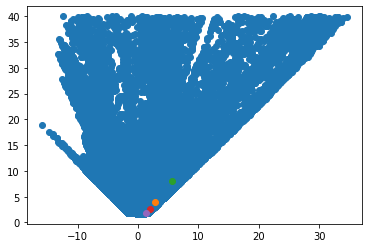

In [12]:
point = point_cloud[550].copy()
plt.scatter(point[:,:,0], point[:,:,2])
plt.scatter(point[150, 430,0], point[150, 430,2])
plt.scatter(point[100, 430,0], point[100, 430,2])
plt.scatter(point[200, 430,0], point[200, 430,2])
plt.scatter(point[250, 430,0], point[250, 430,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


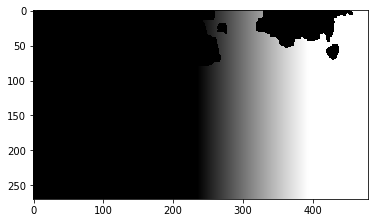

In [193]:
plt.imshow(angle_img/30)
